# Customer Segmentation Using KMeans Clustering

## 1. Load the dataset and set up helper methods

In [175]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [176]:
def remove_outliers(df, columns):
    """
    Remove outliers using IQR method for specified columns.

    Parameters:
    - df: Input DataFrame
    - columns: List of column names to check for outliers

    Returns:
    - DataFrame with outliers removed
    """
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        df_clean = df_clean[(df_clean[col] >= Q1 - 1.5*IQR) & (df_clean[col] <= Q3 + 1.5*IQR)]
    return df_clean

def find_optimal_k(X_scaled, k_range):
    """
    Calculate inertia and silhouette scores for different k values.

    Parameters:
    - X_scaled: Scaled feature matrix
    - k_range: Range of k values to test

    Returns:
    - inertias: List of inertia values
    - silhouette_scores: List of silhouette scores
    - optimal_k: Best k value based on silhouette score
    """
    inertias = []
    silhouette_scores = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X_scaled)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X_scaled, labels))

    optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]
    return inertias, silhouette_scores, optimal_k

def plot_optimization_metrics(k_range, inertias, silhouette_scores):
    """
    Plot elbow method and silhouette scores side by side.

    Parameters:
    - k_range: Range of k values tested
    - inertias: List of inertia values
    - silhouette_scores: List of silhouette scores
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].plot(k_range, inertias, marker='o')
    axes[0].set_xlabel('Number of Clusters (k)')
    axes[0].set_ylabel('Inertia')
    axes[0].set_title('Elbow Method')
    axes[0].grid(True)

    axes[1].plot(k_range, silhouette_scores, marker='o', color='orange')
    axes[1].set_xlabel('Number of Clusters (k)')
    axes[1].set_ylabel('Silhouette Score')
    axes[1].set_title('Silhouette Score Method')
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

def tune_kmeans(X_scaled, k, params_list):
    """
    Compare different KMeans parameter configurations and return the best.

    Parameters:
    - X_scaled: Scaled feature matrix
    - k: Number of clusters
    - params_list: List of parameter dictionaries to test

    Returns:
    - best_model: Best KMeans model
    - best_labels: Cluster labels from best model
    - best_score: Best silhouette score achieved
    """
    best_score = -1
    best_model = None
    best_labels = None

    for params in params_list:
        kmeans = KMeans(n_clusters=k, **params)
        labels = kmeans.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, labels)

        if score > best_score:
            best_score = score
            best_model = kmeans
            best_labels = labels

    return best_model, best_labels, best_score

def plot_clusters_2d(df, x_col, y_col, cluster_col, centers=None, title='Customer Segments'):
    """
    Plot 2D scatter plot of clusters with optional centroids.

    Parameters:
    - df: DataFrame with data and cluster assignments
    - x_col: Column name for x-axis
    - y_col: Column name for y-axis
    - cluster_col: Column name containing cluster labels
    - centers: Optional array of cluster centers
    - title: Plot title
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    scatter = ax.scatter(df[x_col], df[y_col], c=df[cluster_col],
                         cmap='viridis', s=50, alpha=0.6)

    if centers is not None:
        ax.scatter(centers[:, 0], centers[:, 1], c='red', marker='X',
                  s=200, edgecolors='black', label='Centroids')
        ax.legend()

    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title(title)
    plt.colorbar(scatter, ax=ax, label='Cluster')
    plt.tight_layout()
    plt.show()

def generate_cluster_report(df, cluster_col):
    """
    Generate cluster analysis.

    Parameters:
    - df: DataFrame with cluster assignments
    - cluster_col: Column name containing cluster labels

    Returns:
    - DataFrame with cluster summary statistics
    """
    cluster_summary = df.groupby(cluster_col).agg({
        'Annual Income (k$)': 'mean',
        'Spending Score (1-100)': 'mean',
        'CustomerID': 'count'
    }).rename(columns={'CustomerID': 'Count'}).round(2)

    cluster_summary = cluster_summary.sort_values('Spending Score (1-100)', ascending=False)
    return cluster_summary

def assign_cluster_names(cluster_summary):
    """
    Assign business-friendly names to clusters based on characteristics.

    Parameters:
    - cluster_summary: DataFrame with cluster statistics

    Returns:
    - Dictionary mapping cluster IDs to names
    """
    cluster_names = {}
    for cluster_id in cluster_summary.index:
        income = cluster_summary.loc[cluster_id, 'Annual Income (k$)']
        spending = cluster_summary.loc[cluster_id, 'Spending Score (1-100)']

        if income > 90 and spending > 70:
            cluster_names[cluster_id] = "Premium VIP"
        elif income > 70 and spending > 70:
            cluster_names[cluster_id] = "High-Value Regulars"
        elif income < 40 and spending > 70:
            cluster_names[cluster_id] = "Young Enthusiasts"
        elif income < 40 and spending < 30:
            cluster_names[cluster_id] = "Budget Conscious"
        elif income > 70 and spending < 30:
            cluster_names[cluster_id] = "Conservative Wealthy"
        else:
            cluster_names[cluster_id] = "Average Customers"

    return cluster_names

def generate_marketing_report(df, cluster_col='Cluster'):
    """
    Generate detailed marketing report with cluster analysis and recommendations.

    Parameters:
    - df: DataFrame with cluster assignments
    - cluster_col: Column name containing cluster labels

    Returns:
    - DataFrame with detailed cluster analysis and cluster names dictionary
    """
    cluster_summary = generate_cluster_report(df, cluster_col)
    cluster_names = assign_cluster_names(cluster_summary)

    cluster_details = df.groupby(cluster_col).agg({
        'Annual Income (k$)': 'mean',
        'Spending Score (1-100)': 'mean',
        'CustomerID': 'count'
    }).rename(columns={'CustomerID': 'Count'}).round(2)

    cluster_details['Cluster_Name'] = cluster_details.index.map(cluster_names)
    cluster_details['Percentage'] = (cluster_details['Count'] / len(df) * 100).round(1)

    cluster_details = cluster_details[['Cluster_Name', 'Count', 'Percentage',
                                       'Annual Income (k$)', 'Spending Score (1-100)']]
    cluster_details = cluster_details.sort_values('Spending Score (1-100)', ascending=False)

    return cluster_details, cluster_names

### Explore dataset

In [177]:
df = pd.read_csv('mall_customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [178]:
df.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [180]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


## 2. Basic Preprocessing

In [181]:
df = remove_outliers(df, ['Annual Income (k$)', 'Spending Score (1-100)'])
print(f"Shape after removing outliers: {df.shape}")

Shape after removing outliers: (198, 5)


## 3. Correlation Analysis and Feature Selection

In [182]:
df['Gender_Encoded'] = df['Gender'].map({'Male': 0, 'Female': 1})

correlation_data = df[['Age', 'Gender_Encoded', 'Spending Score (1-100)']].corr()
print(correlation_data)

                             Age  Gender_Encoded  Spending Score (1-100)
Age                     1.000000       -0.067835               -0.329421
Gender_Encoded         -0.067835        1.000000                0.059092
Spending Score (1-100) -0.329421        0.059092                1.000000


**Decision**: Based on the correlation analysis:
- Age correlation with Spending Score: -0.329 (weak negative)
- Gender correlation with Spending Score: 0.059 (very weak)

Both correlations are weak, so we exclude Age and Gender from clustering and use only Annual Income and Spending Score.

In [183]:
X = df[['Annual Income (k$)', 'Spending Score (1-100)']]

## 4. KMeans Clustering with and without Scaling

In [184]:
kmeans_no_scale = KMeans(n_clusters=5, random_state=42)
clusters_no_scale = kmeans_no_scale.fit_predict(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
kmeans_scaled = KMeans(n_clusters=5, random_state=42)
clusters_scaled = kmeans_scaled.fit_predict(X_scaled)

print(f"Without scaling: {kmeans_no_scale.inertia_:.2f}")
print(f"With scaling: {kmeans_scaled.inertia_:.2f}")

Without scaling: 63508.16
With scaling: 98.20


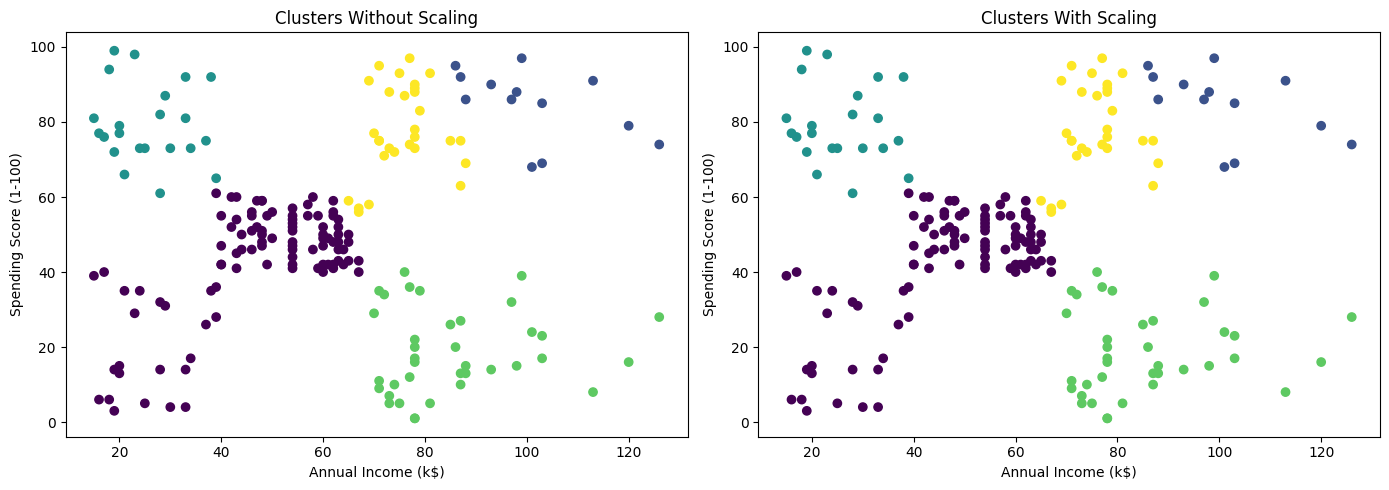

In [185]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(X.iloc[:, 0], X.iloc[:, 1], c=clusters_no_scale, cmap='viridis')
axes[0].set_xlabel('Annual Income (k$)')
axes[0].set_ylabel('Spending Score (1-100)')
axes[0].set_title('Clusters Without Scaling')

axes[1].scatter(X.iloc[:, 0], X.iloc[:, 1], c=clusters_scaled, cmap='viridis')
axes[1].set_xlabel('Annual Income (k$)')
axes[1].set_ylabel('Spending Score (1-100)')
axes[1].set_title('Clusters With Scaling')

plt.tight_layout()
plt.show()

**Decision on Scaling**: Both features (Annual Income and Spending Score) have similar scales and ranges, so scaling doesn't significantly change the clustering results. We'll proceed with scaled data for consistency with best practices.

## 5. Determine Optimal k Using Elbow Method and Silhouette Score

In [186]:
k_range = range(2, 11)
inertias, silhouette_scores, optimal_k = find_optimal_k(X_scaled, k_range)

print(f"Optimal k based on Silhouette Score: {optimal_k}")
print(f"Max Silhouette Score: {max(silhouette_scores):.3f}")

Optimal k based on Silhouette Score: 6
Max Silhouette Score: 0.540


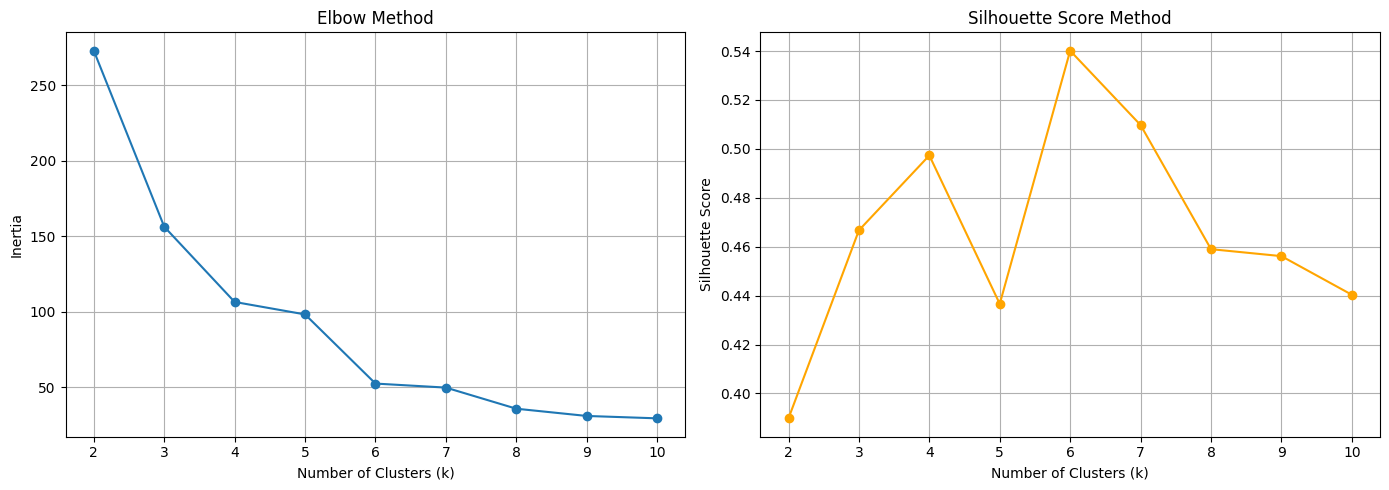

In [187]:
plot_optimization_metrics(k_range, inertias, silhouette_scores)

## 6. Tune KMeans Parameters

In [188]:
params_list = [
    {'random_state': 42},
    {'init': 'k-means++', 'n_init': 20, 'max_iter': 500, 'random_state': 42}
]
best_kmeans, best_labels, best_score = tune_kmeans(X_scaled, optimal_k, params_list)
print(f"Best silhouette score: {best_score:.3f}")

Best silhouette score: 0.540


**Decision**: Selected the parameters with better silhouette score for final clustering.

In [189]:
df['Cluster'] = best_labels

## 7. Visualize Clusters

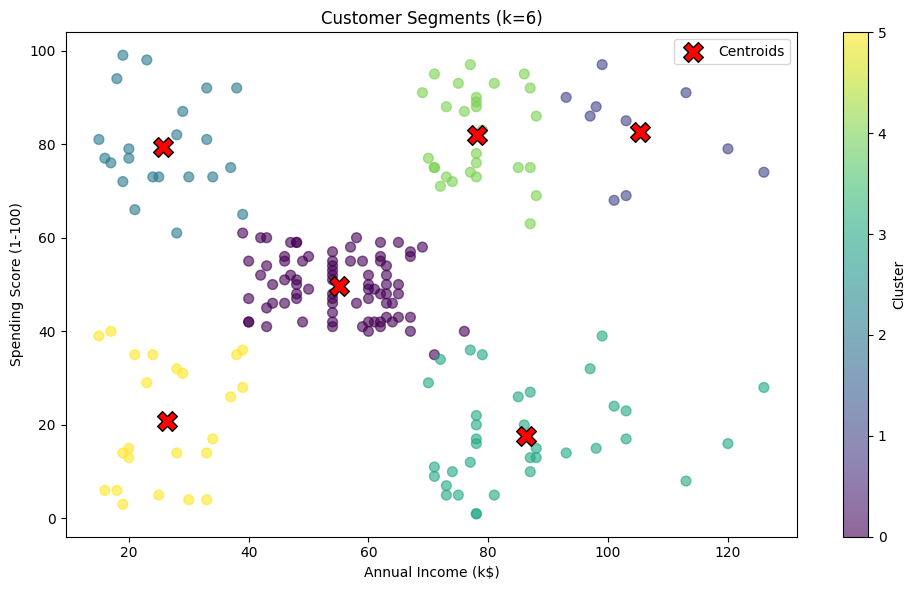

In [190]:
centers = scaler.inverse_transform(best_kmeans.cluster_centers_)
plot_clusters_2d(df, 'Annual Income (k$)', 'Spending Score (1-100)', 'Cluster', centers, f'Customer Segments (k={optimal_k})')

## 8. Identify High-Spending Clusters for Marketing

In [191]:
cluster_summary = generate_cluster_report(df, 'Cluster')
print(cluster_summary)

         Annual Income (k$)  Spending Score (1-100)  Count
Cluster                                                   
1                    105.30                   82.70     10
4                     78.04                   81.89     28
2                     25.73                   79.36     22
0                     55.09                   49.71     80
5                     26.30                   20.91     23
3                     86.34                   17.57     35


In [192]:
high_spending_clusters = cluster_summary[cluster_summary['Spending Score (1-100)'] > 60].index.tolist()
print(f"\nHigh-spending clusters (Spending Score > 60): {high_spending_clusters}")
print(f"Total customers in high-spending segments: {cluster_summary.loc[high_spending_clusters, 'Count'].sum():.0f}")


High-spending clusters (Spending Score > 60): [1, 4, 2]
Total customers in high-spending segments: 60


**Marketing Insights**: Target clusters with high spending scores for premium product campaigns and loyalty programs. Focus on retaining these valuable customer segments.

In [193]:
cluster_details, cluster_names = generate_marketing_report(df, 'Cluster')

df['Cluster_Name'] = df['Cluster'].map(cluster_names)

print("Detailed Cluster Analysis:")
print(cluster_details)
print("\n" + "="*70)
print("MARKETING REPORT")
print("="*70)

for cluster_id in cluster_details.index:
    name = cluster_names[cluster_id]
    count = cluster_details.loc[cluster_id, 'Count']
    pct = cluster_details.loc[cluster_id, 'Percentage']
    income = cluster_details.loc[cluster_id, 'Annual Income (k$)']
    spending = cluster_details.loc[cluster_id, 'Spending Score (1-100)']

    print(f"\nCluster {cluster_id}: {name}")
    print(f"  Size: {count} customers ({pct}% of total)")
    print(f"  Average Income: ${income}k")
    print(f"  Average Spending Score: {spending}/100")

    if spending > 70:
        priority = "HIGH"
        action = "Premium campaigns, VIP programs, exclusive offers"
    elif spending > 40:
        priority = "MEDIUM"
        action = "Standard marketing, seasonal promotions"
    else:
        priority = "LOW"
        action = "Minimal investment, clearance sales only"

    print(f"  Priority: {priority}")
    print(f"  Recommended Action: {action}")

print("\n" + "="*70)
print("SUMMARY")
print("="*70)
high_value_count = cluster_details[cluster_details['Spending Score (1-100)'] > 70]['Count'].sum()
high_value_pct = (high_value_count / len(df) * 100).round(1)
print(f"High-value customers (spending > 70): {high_value_count} ({high_value_pct}%)")
print(f"Primary target: Cluster 4 (High-Value Regulars) - largest high-spending segment")
print(f"Secondary targets: Clusters 1 and 2 for specialized campaigns")

Detailed Cluster Analysis:
                 Cluster_Name  Count  Percentage  Annual Income (k$)  \
Cluster                                                                
1                 Premium VIP     10         5.1              105.30   
4         High-Value Regulars     28        14.1               78.04   
2           Young Enthusiasts     22        11.1               25.73   
0           Average Customers     80        40.4               55.09   
5            Budget Conscious     23        11.6               26.30   
3        Conservative Wealthy     35        17.7               86.34   

         Spending Score (1-100)  
Cluster                          
1                         82.70  
4                         81.89  
2                         79.36  
0                         49.71  
5                         20.91  
3                         17.57  

MARKETING REPORT

Cluster 1: Premium VIP
  Size: 10 customers (5.1% of total)
  Average Income: $105.3k
  Average Spending 